# Recognize Phones from Speech Sentences using Hidden Markov Model
## Preliminary Testing on a SINGLE vowel

For this project, a hidden markov model (HMM) is applied to create phone models for three different vowels (/a/, /u/, /i/). Then all three phone models are used to infer the state of a given speech sentence. The objective is to recognize the three phones from any given sentence with their corresponding time indices.

In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import scipy.io as sio
import numpy as np
import pandas as pd

from hmmlearn_YG import hmm
from python_speech_features import mfcc

### Hidden Markov Models

[HMMs](https://en.wikipedia.org/wiki/Hidden_Markov_model) are a class of probabilistic graphical models that can predict the sequence of states, given a sequence of observations that are dependent on those states, and when the states themselves are unobservable. HMMs have seen widespread success in a variety of applications, from Speech processing and Robotics to DNA Sequencing. An HMM operates according to a set of assumptions, which are :  
1. **Markov Assumption**  
Current state is dependent on only the previous state.  
2. **Stationarity Assumption**  
Transition probabilities are independent of time of transition.  
3. **Independence Assumption**  
Each observation depends solely on the current underlying state (which in turn depends on the previous one), and is independent of other observations.  

An HMM is a **Generative model**, in that it attempts to find the probability of a set of observations being produced or *generated* by a class.  The parameters that we pass to the HMM class, defined below, are:  
$O$ = a set of observations  
$S$ = a set of states  
$A$ = transition probabilities, represented as a matrix  
$B$ = emission probabilities, represented as a matrix  
$\pi$ = initial state probabilties  
$Y$ = sequence observed  

## 1. Load Vowel Data for Training the HMM
Load one normal vowels (/a/ normal, /u/ normal, /i/ normal) but only using voice channels, the normal vowels are used for fitting the Hidden Markov Model, generate all hidden state distributions.

In [2]:
# Select Subject and Vowel
subject = "R031"
vowel = "a_normal"

In [3]:
# Extract variables that contain related data
vowel_np = np.load("Data/%s/voice_%s.npy" % (subject, vowel))
print(vowel_np.shape)

(55, 2)


## 3. Extract Features from Vowels
Load the vowels and extrac MFCC features from each repetition to construct the training vectors to train the HMM model
### Mel Frequency Cepstral Coefficient (MFCC) 
1. Frame the signal into short frames.
2. For each frame calculate the periodogram estimate of the power spectrum.
3. Apply the mel filterbank to the power spectra, sum the energy in each filter.
4. Take the logarithm of all filterbank energies.
5. Take the DCT of the log filterbank energies.
6. Keep DCT coefficients 2-13, discard the rest.

Example:
<img src="Figure/time_signal.jpg" width="700"/>
<img src="Figure/mfcc_raw.jpg" width="700"/>

### Reference
Davis, S. Mermelstein, P. (1980) Comparison of Parametric Representations for Monosyllabic Word Recognition in Continuously Spoken Sentences. In IEEE Transactions on Acoustics, Speech, and Signal Processing, Vol. 28 No. 4, pp. 357-366

X. Huang, A. Acero, and H. Hon. Spoken Language Processing: A guide to theory, algorithm, and system development. Prentice Hall, 2001.

In [4]:
mfcc_feat = mfcc(vowel_np[0,0], vowel_np[0,1], 
                 0.025, 0.01)
print("Original dimension of voice signal: ", vowel_np[0,0].shape)
print("Dimension of extracted features: ", mfcc_feat.shape)

Original dimension of voice signal:  (27801,)
Dimension of extracted features:  (138, 13)


In [5]:
vowel_feature = np.empty((0,13))
length = []
for vowel_sample, vowel_rate in vowel_np[1:55]:
    # MFCC feature vectors are typically computed every 10ms using 
    # an overlapping analysis window of 25ms
    mfcc_feat = mfcc(vowel_sample, vowel_rate, 
                     0.025, 0.01)
    
    # Concatnate individual feature into one single array
    vowel_feature = np.append(vowel_feature, mfcc_feat, axis=0)
    length.append(int(mfcc_feat.shape[0]))

In [6]:
print('Total # of feature sequences: ', length)

Total # of feature sequences:  [166, 162, 170, 168, 164, 173, 129, 154, 157, 163, 159, 150, 157, 164, 173, 160, 151, 169, 164, 147, 156, 170, 160, 164, 159, 158, 153, 165, 160, 167, 153, 161, 160, 161, 153, 163, 150, 156, 163, 160, 158, 141, 139, 155, 159, 140, 150, 152, 158, 149, 149, 158, 133, 134]


## 4. Training a HMM Model
Use Gaussian distribution for estimating emission probabilities

In [7]:
num_components = 3

# Initialize HMM model and estimate parameters for base phone
transmat = np.matrix([[0.5, 0.5, 0],
                      [0, 0.5, 0.5],
                      [0, 0, 1]])

print("State transition probability matrix:\n", transmat)

# Always start in first state
startprob = np.zeros(3)
startprob[0] = 1.0

print("State initial probabilities:\n",startprob)

State transition probability matrix:
 [[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
State initial probabilities:
 [1. 0. 0.]


### To Do
Investigate clustering algorithm for the initialization of the HMM parameter estimation

In [25]:
model_vowel = hmm.GaussianHMM(n_components=num_components,  
                              covariance_type="full",
                              params="mct", 
                              init_params="cm",
                              n_iter=100)

model_vowel.startprob = startprob.copy()
model_vowel.transmat_ = transmat.copy()

model_vowel.fit(vowel_feature, length)
model_vowel.monitor_

[[ -6.56645508  13.0385565  -23.76816498 -33.01775959 -21.70718309
  -13.81905092   9.3968266    1.44434925 -22.25156454  -6.20606715
  -25.80682409  -2.09674947 -25.29217092]
 [ -6.3784235   15.26545786 -19.73458015 -25.76126336 -18.64328816
   -8.6990386   18.53459925   7.99068895 -15.77050795  -2.67641817
  -18.92565295   2.00382344 -19.11416106]
 [-12.11343769   1.87478829  14.24962756  -2.71361536   6.32537912
    6.60008472   1.96656373  -7.48013703 -11.40743456  -6.38934953
   -9.73417406  -9.92346796 -12.81800235]]


ConvergenceMonitor(history=[-296871.3076972699, -296871.29994244274], iter=14,
          n_iter=100, tol=0.01, verbose=False)

In [10]:
print(model_vowel.means_)

[[ -6.20986978  14.88036541 -20.87459932 -27.23020994 -21.55687525
  -12.47276765  17.4521147    7.98966483 -19.1896724   -5.57549676
  -20.02461812   0.694798   -19.7447831 ]
 [ -9.4921205   10.45594109  -1.21397884 -20.09580085  -9.29913011
   -1.67088007   6.48262617  -2.87999337 -15.1323314   -5.35241945
  -18.87519908  -5.00368577 -18.61841877]
 [ -6.81128496  13.06525973 -22.70268225 -30.7384168  -17.18382281
   -8.62611642  10.52128599   1.14778669 -17.62211984  -2.13869046
  -24.25284261  -0.45818098 -24.64680106]]


### To-Do: 
Re-order the state sequence based on the variance of that particular state. The intuition here is assuming that the empty (quiet) state 0 has the smallest variance; the beginning state 1 of a vowel has the medium amount of variance; and the main vowel state 2 should have the largest variance.
### !!!!!Note to myself!!!!!
Inside GaussianHMM class, \_init function, there is a step uses kmean to cluster given observations for the initial estimation of means

## 5. Use Trainned HMM Model to Perform State Prediction on Given Voices
Use the three HMM models which are estimated previously for /a/ normal, /u/ normal, /i/ normal to:
1. Find corresponding states on original vowel signals for reference.
2. Predict corresponding states for given syllables to validate the models.
3. Predict corresponding states for given sentences to test the models.

### 5.1 Use vowels as tesing voice signal

#### Function: Load testing voice (vowels or speeches), extract features
Similar to the function of loading training vowels. However, this only loads one repetition for qualitative analysis.

#### Function: Restore states prediction from the feature space to the original signal space
The voice feature vectors are extracted every 10ms using a 25ms overlapping window. Thus, each predicted state for the feature vector need to be expanded to the original voice signal in order to get the indices for the start and end for the states.

In [11]:
color_vec = ['r','g','y','c','m']

In [12]:
def predict_voice_state(model, voice_sample, voice_feature, c, L):
    """ THIS PARAMETER NEED TO BE FURTHER INVESTIGATED """
    # sample window = time x sampling rate
    sample_window = int(0.01 * 20000)
    """ THIS PARAMETER NEED TO BE FURTHER INVESTIGATED """

    # Use trainned HMM to predict the states
    state_prediction = model.predict(voice_feature)
    state_length = len(state_prediction)

#     print(state_prediction)

    # Expand the state prediction from feature vectors to the original
    # voice signals
    # i - index
    # s - state
    voice_state = np.zeros((num_components,voice_sample.size))
    for i,s in enumerate(state_prediction):

        # Skip the first and last state to make it able to detect 
        # after differentiation
        # the first state
        if i == 0:
            for j in range(1, sample_window):
                voice_state[s,j] = 1
        # from the second state until the second last state
        elif i < state_length - 1:
            for j in range(i*sample_window, i*sample_window+sample_window):
                voice_state[s,j] = 1
        # last state
        else:
            for j in range(i*sample_window, voice_sample.size-1):
                voice_state[s,j] = 1

    # Plot the expanded voice state sequence
    plt.figure(2, figsize=(15, 6))
    plt.plot(voice_sample, c='b', alpha=0.8)
#     c = ['r','g','y']

    for s in range(0,num_components):
        i_start = []    # all start indices for the current state
        i_end   = []    # all end indices for the current state

        # peform the differentiation
        voice_detect = np.diff(voice_state[s,:])
        # find non-zero elements +1/-1
        for i, v in enumerate(voice_detect):
            if v == 1:
                i_start.append(i)
            elif v == -1:
                i_end.append(i)

        for i,j in zip(i_start, i_end):
            p = plt.axvspan(i, j, facecolor=c[s] , alpha=0.4)

    plt.xlim(L[0], L[1])    
    plt.show()

#### load testing vowels

In [13]:
voice_te, vowel_rate = vowel_np[0]
feature_te = mfcc(vowel_sample, vowel_rate, 
                 0.025, 0.01)

#### Predict testing vowels
State sequence order: red   ---> 0, green ---> 1, yello ---> 2
### !!!!!Note to myself!!!!!
The state prediction for a testing vowel would depend largely from the results of clustering

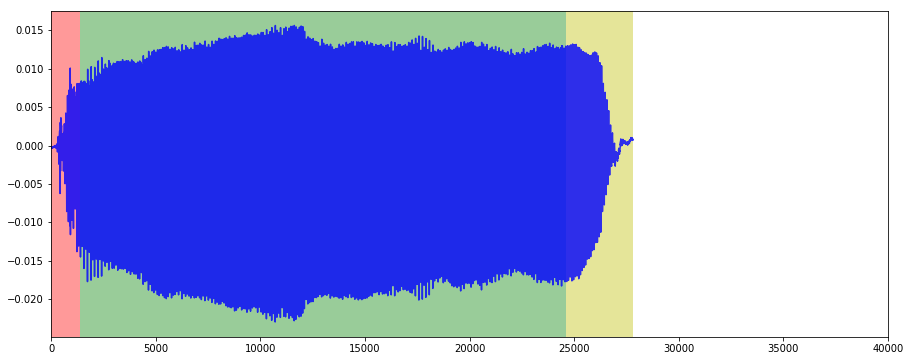

In [26]:
predict_voice_state(model_vowel, voice_te, feature_te, color_vec, [0, 40000])

In [27]:
# save the results of mean and covariance for good states prediction
np.save('Stat/%s/%s_mean_02.npy' % (subject, vowel), model_vowel.means_)
np.save('Stat/%s/%s_cov_02.npy' % (subject, vowel), model_vowel.covars_)

np.savetxt('Stat/%s/%s_mean_02.txt' % (subject, vowel), model_vowel.means_, fmt='%.4e')

### 5.2 Using syllable1 as tesing voice signal

“afa afa afa ifi ifi ifi ufu ufu ufu”

In [ ]:
syllable = sio.loadmat('Data/%s/syllable1.mat' % subject)

In [ ]:
voice_syl_te, feature_syl_te, length_syl_te = load_voice_testing(syllable, 0, [0,120000])
predict_voice_state(model_vowel, voice_syl_te, feature_syl_te, color_vec, [0,120000])

zoom in the first part of this syllable sequence to better evaluate "afa afa afa"

In [ ]:
voice_syl_te, feature_syl_te, length_syl_te = load_voice_testing(syllable, 0, [0,30000])
predict_voice_state(model_vowel, voice_syl_te, feature_syl_te, color_vec, [0,30000])

### 5.3 Using sentence as tesing voice signal
<img src="Figure/sentence_ref.png" width="500"/>

### Reference
Y.-A. Lien, C. Gattuccio, and C. Stepp, “Effects of phonetic context on relative fundamental frequency,” Journal of Speech, Language, and Hearing Research, vol. 57, pp. 1259–1267, 2014.

Elizabeth S.Heller Murray, Gabrielle L. Hands, Carolyn R. Calabrese, Cara E. Stepp, Effects of Adventitious Acute Vocal Trauma: Relative Fundamental Frequency and Listener Perception, Journal of Voice, Volume 30, Issue 2, 2016, Pages 177-185.

##### Sentence 1 
“The d**ew shi**mmered over m**y shi**ny blue shell again”

In [ ]:
sentence1 = sio.loadmat('Data/%s/sentence1.mat' % subject)
voice_stn_te, feature_stn_te, length_stn_te = load_voice_testing(sentence1, 0, [0, 60000])
predict_voice_state(model_vowel, voice_stn_te, feature_stn_te, color_vec,[0, 60000])

##### Sentence 2
“Only w**e fee**l you d**o fai**l in n**ew fa**llen dew”

In [ ]:
sentence2 = sio.loadmat('Data/%s/sentence2.mat' % subject)
voice_stn_te, feature_stn_te, length_stn_te = load_voice_testing(sentence2, 0, [0, 60000])
predict_voice_state(model_vowel, voice_stn_te, feature_stn_te, color_vec,[0, 60000])